In [377]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, least_squares 
from tqdm import tqdm

In [378]:
##Import the excel file 
sensor_df = pd.read_csv('104.csv')

#Down sample to every 100
sensor_df_smol = sensor_df[0:100000:100]
sensor_df_smol.head()

,sensor ID,norm_secs (secs),time (days)
0,63802,0.000000,39416.607535
100,415483,4.500004,39416.607587
200,161919,9.000008,39416.607639
300,943442,12.500011,39416.607679
400,194738,16.500015,39416.607726


In [379]:
#Import the SMOL attack csv instead of downsampling
sensor_df_smol = pd.read_csv('062.csv')
backbone_sensor_df = sensor_df_smol 
backbone_sensor_df.head()

,sensor ID,norm_secs (secs),time (days)
0,15,11.200029,39423.442618
1,15,11.900031,39423.442626
2,15,12.600032,39423.442634
3,15,13.300034,39423.442642
4,15,14.000036,39423.442650


In [380]:
print(backbone_sensor_df.shape)
print(sensor_df_smol.shape)
print(backbone_sensor_df['sensor ID'].nunique())

(58047, 3)
(58047, 3)
60


In [431]:
#function to check total time between gateways and returns average time
def gateway_total(gateway_x, gateway_y):
    count = 0
    time = 0
    size = backbone_sensor_df.shape[0]
    gateway_path = backbone_sensor_df.values
    
    #hyperparameter
    hops = 5
    
    for x in range(size):
        if (gateway_path[x][0] == gateway_x):
            #if it's in the last few indexes just check the rest
            if ( x > size-hops):
                for i in range(size-x):
                    if (gateway_path[x+i][0] == gateway_y):
                        count += 1
                        time += abs(gateway_path[x-i][1] - gateway_path[x][1])
            #check the next number of hops
            else:
                for i in range(hops):
                    if (gateway_path[x+i][0] == gateway_y):
                        count += 1
                        time += abs(gateway_path[x+i][1] - gateway_path[x][1])
                                        
    if (count >= 1): 
        #print(count)
        return time/count
    else:
        return 0 #could change this to a negative number to indicate doesn't exist 
        
gateway_total(1,20)

0

In [432]:
#set up a matrix of time between adjacent gateways, this is a proxy for distance
num_gates = backbone_sensor_df['sensor ID'].nunique()
time_pairs = np.zeros((num_gates,num_gates))
gateway_ids = backbone_sensor_df['sensor ID'].drop_duplicates().values

for x in tqdm(range(num_gates)):
    #times = []
    for y in range(num_gates):
        #find how many times x gateway is adjacent to y gateway 
        gateway_id_x = gateway_ids[y]
        gateway_id_y = gateway_ids[x]
        average = gateway_total(gateway_id_x,gateway_id_y)

        #add to time_pairs[x][y]
        time_pairs[x][y] = average
        
        
time_pairs

100%|██████████| 60/60 [00:55<00:00,  1.08it/s]


array([[  4.66821057,   4.87509729, 202.12551999, ...,   0.        ,
          0.        ,   0.        ],
       [  8.78430313,   1.46170589, 134.67256869, ...,   0.        ,
         54.60014047,   0.        ],
       [ 64.15785736,  25.83578075,   2.6433772 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  28.63007365,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          1.32310946,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,  12.55428066]])

In [433]:
#get the average velocity from the ground truth data 
avg_vel = 2 #m/s

In [434]:
#calculate the distance matrix from the average time and average velocity 
distance = avg_vel*time_pairs
distance
print(distance.shape)

(60, 60)


In [435]:
#pick three gateways to triangulate from ground truth
gateway_a = [231.2663,120.1813]
gateway_b = [197.9663,793.9513]
gateway_c = [757.0289,350.5063]

x1 = gateway_a[0]
y1 = gateway_a[1]

x2 = gateway_b[0]
y2 = gateway_b[1]

x3 = gateway_c[0]
y3 = gateway_c[1]



In [436]:
#function to return the distance error between points
def distance_err(point):
    x = point[0]
    y = point[1]
    error1 = np.abs(np.linalg.norm(np.array([x,y])-np.array([x1,y1])) - d1)**2
    error2 = np.abs(np.linalg.norm(np.array([x,y])-np.array([x2,y2])) - d2)**2
    error3 = np.abs(np.linalg.norm(np.array([x,y])-np.array([x3,y3])) - d3)**2
    error_total = error1 + error2 + error3
    
    return error_total 

#Example use of 
#least_squares(fun,[16000,25000])

In [437]:
#for each gateway get the location 
positions_x = []
positions_y = []

#loop through gateways 
for i in range(len(gateway_ids)):
    gateway = gateway_ids[i]
    d1 = distance[i][0]
    d2 = distance[i][27]
    d3 = distance[i][3]
    
    positions_x.append(least_squares(distance_err,[400,400]).x[0])
    positions_y.append(least_squares(distance_err,[400,400]).x[1])

zipped = list(zip(gateway_ids,positions_x,positions_y))
positions = pd.DataFrame(zipped, columns = ['gateway_ids','positions_x','positions_y'])
positions.head()

,gateway_ids,positions_x,positions_y
0,15,302.983685,443.694054
1,34,308.594925,446.036204
2,19,335.257076,485.726544
3,49,443.474941,515.434470
4,9,339.224095,713.579048


In [438]:
##Import the excel file 
truth_df = pd.read_csv('sensors.csv')
truth_df.head()

gateway_ids

#get the ground truth values for the gateway ids of interest
truth_df_filtered = truth_df[truth_df['sensor ID'].isin(gateway_ids)]
truth_df_filtered.head()

,sensor ID,x (m),y (m),radius (m)
0,0,231.2663,120.1813,11.131326
1,1,371.8589,238.2076,11.634567
2,2,757.0289,350.5063,15.115731
3,3,190.9400,140.1613,13.697470
4,4,663.1340,522.3010,14.227241


In [439]:
#get gateway_id position error 

error = np.zeros(60)
for i in range(len(gateway_ids)):
    gateway = gateway_ids[i]
    truth_data = truth_df[truth_df['sensor ID'] == gateway]
    x = truth_data['x (m)'].values
    y = truth_data['y (m)'].values
    
    position_data = positions[positions['gateway_ids'] == gateway]
    x_est = position_data['positions_x'].values
    y_est = position_data['positions_y'].values
    
    error[i] = np.linalg.norm(np.array([x,y])-np.array([x_est,y_est]))
    
print(error)

[500.88478248 480.70238334 467.3191978  450.42051831 559.8955896
 266.97419367 353.10862503 937.94934768 287.71059359 357.13510766
 399.318443   437.7739866  482.04325375 286.0455173  409.09307286
 481.34161196 213.85270487 217.20766582 225.62842278 254.91380439
 186.71114864 300.51109141 274.32222939 299.72494789 301.86854476
 295.54384458 241.16626988 370.94819758 344.06287924 323.86376926
 368.52040651 401.03900499 649.3931879  386.18554012 337.95639409
 359.69908788 399.05762173 186.24364307 796.99566878 372.43550633
 526.1056056  414.3297827  380.74633105 429.06205646 418.38914767
 342.00126719 352.811711   438.0515301   33.37909101 421.51361164
 410.52512583 333.15380282 332.03543036 381.70401895 407.6871241
 558.77988037 252.05510798 529.95698031 238.11174538 437.062473  ]


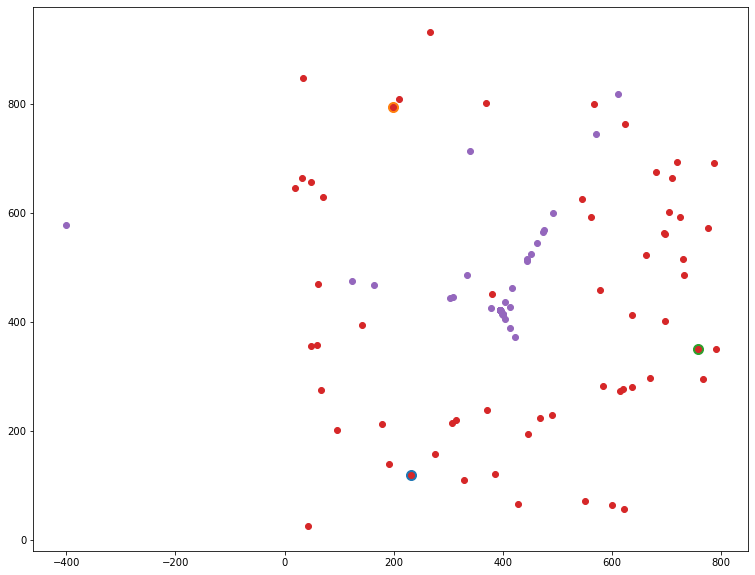

In [440]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18, 10))
plt.gca().set_aspect("equal")
plt.scatter(x1,y1,s=100,marker='o')
plt.scatter(x2,y2,s=100,marker='o')
plt.scatter(x3,y3,s=100,marker='o')
plt.scatter(truth_df_filtered["x (m)"], truth_df_filtered["y (m)"])
plt.scatter(positions['positions_x'], positions['positions_y'])
plt.show()

In [ ]:
#bring in other sensor traces 
#figure out your for loopin problem 

In [ ]:
#Unused function to check how many times gateways are next to each other and return average time 
def gateway_adjacent(gateway_x, gateway_y):
    #print(gateway_x)
    #print(gateway_y)
    
    count = 0
    time = 0
    size = backbone_sensor_df.shape[0]
    #print(size)
    for x in range(size):
        if (backbone_sensor_df.iloc[x][0] == gateway_x):
            #if it's the first index 
            if (x == 0):
                if (backbone_sensor_df.iloc[x+1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+1][1] - backbone_sensor_df.iloc[x][1])
            
            #if it's a last index
            elif (x == size-1):
                if (backbone_sensor_df.iloc[x-1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-1][1] - backbone_sensor_df.iloc[x][1])
            
            else:
                if (backbone_sensor_df.iloc[x+1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+1][1] - backbone_sensor_df.iloc[x][1])
                elif (backbone_sensor_df.iloc[x-1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-1][1] - backbone_sensor_df.iloc[x][1])
                    
    if (count >= 1): 
        return time/count
    else:
        return 0

In [ ]:
#filter to adjadent gateways with a time difference larger than 3 seconds

#take this out? Can we just use the smol attack data directly

#diff_sensor_df = sensor_df_smol.diff()
#print(diff_sensor_df[40:60])
#print(sensor_df_smol[40:60])
#[diff_sensor_df['norm_secs (secs)'] > 5]

#backbone_sensor_df = sensor_df_smol 
#backbone_sensor_df.head()